## Plot sample Images

In [8]:
#from src.utils import track_files, plot_image_grid

from glob import glob
DATA_DIR = "data/diabetic-retinopathy-dataset/resized/train/"
image_files = glob(DATA_DIR + "*")
#image_files = track_files(DATA_DIR)

#plot_image_grid(image_files, roi_crop=True)

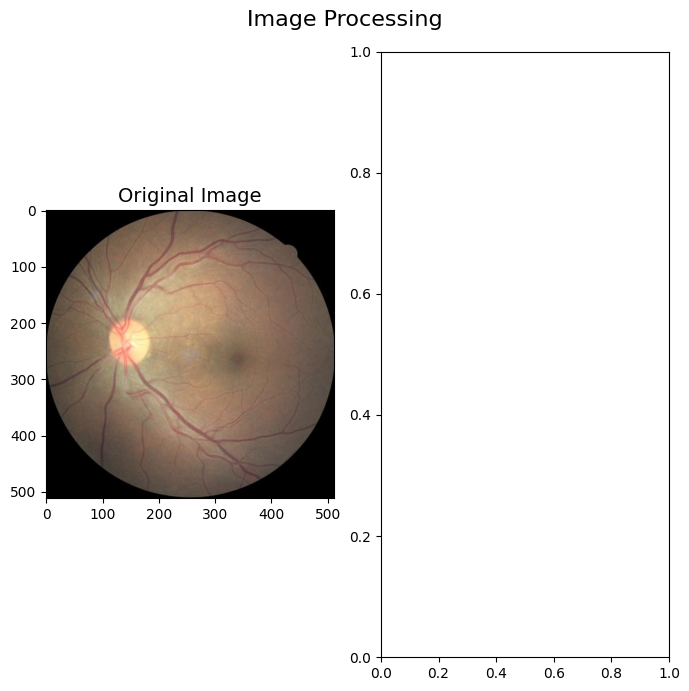

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
#from src.utils import crop_and_pad_image
#from torchvision import transforms as T

# Load the source image
image_path = image_files[0]  # Assuming image_files is defined elsewhere
src_image = Image.open(image_path)


# Plotting
fig, axes = plt.subplots(1, 2, figsize=(7, 7))

# Plot source image with title
axes[0].imshow(src_image)
axes[0].set_title("Original Image", fontsize=14)


# Add title to the entire figure
fig.suptitle("Image Processing", fontsize=16)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [4]:
print(image_files)

['data/diabetic-retinopathy-dataset/resized/train/10003_left.jpeg', 'data/diabetic-retinopathy-dataset/resized/train/10003_left_mask.jpeg', 'data/diabetic-retinopathy-dataset/resized/train/10003_right.jpeg', 'data/diabetic-retinopathy-dataset/resized/train/10003_right_mask.jpeg', 'data/diabetic-retinopathy-dataset/resized/train/10007_left.jpeg', 'data/diabetic-retinopathy-dataset/resized/train/10007_left_mask.jpeg', 'data/diabetic-retinopathy-dataset/resized/train/10007_right.jpeg', 'data/diabetic-retinopathy-dataset/resized/train/10007_right_mask.jpeg', 'data/diabetic-retinopathy-dataset/resized/train/10009_left.jpeg', 'data/diabetic-retinopathy-dataset/resized/train/10009_left_mask.jpeg', 'data/diabetic-retinopathy-dataset/resized/train/10009_right.jpeg', 'data/diabetic-retinopathy-dataset/resized/train/10009_right_mask.jpeg', 'data/diabetic-retinopathy-dataset/resized/train/1000_left.jpeg', 'data/diabetic-retinopathy-dataset/resized/train/1000_left_mask.jpeg', 'data/diabetic-retinop

#### **Ridge filtering and vessel detection**
We have changed the original project, which is about detecting diabetic retinopathy, to detection optical vessels in the image. This problem is equally important and we do not have annotated vessels, which makes this problem more challenging and interesting.

##### **1. Unsupervised vessel detection to generate vessel annotations**

To train a deep-learning model to segment optical vessels, we need training data. We can get some kind of imperfect labels using unsupervised computer-vision techniques (filters, morphology etc) to detect vessels. These annotations don't need to be perfect and can be fed to a model. The expectation from the model is to take these imperfect annotations and 'denoise' them i.e learn the vessel features and produce better vessel annotations

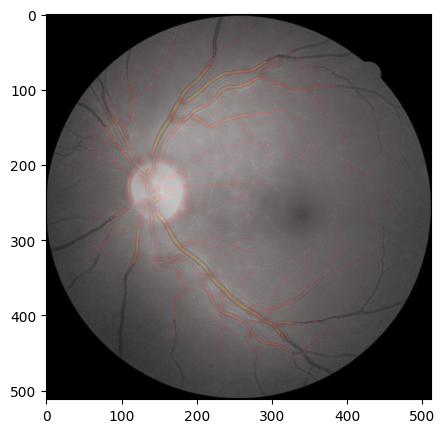

In [10]:
from skimage.filters.ridges import sato, frangi
import numpy as np
import dataloader

plt.rcParams["figure.figsize"] = (5, 5)

sig = [2]
img_np = np.array(Image.open(image_path).convert('L'))

img_np = dataloader.zscore_norm(img_np)
#ridge = frangi(img_np, sigmas=[12, 14, 16, 18])
ridge = sato(img_np, sigmas=sig)

plt.imshow(img_np, cmap='gray')
plt.imshow((img_np>0)*ridge, cmap='hot', alpha=0.2)

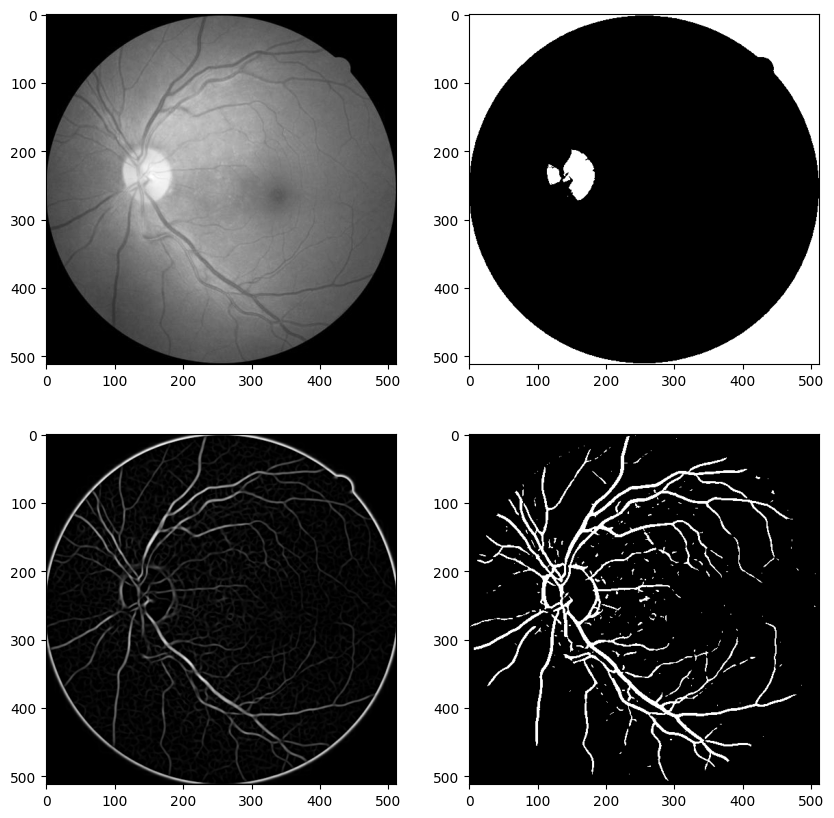

In [19]:
import numpy as np

plt.rcParams["figure.figsize"] = (10, 10)
vt_lower = 0
vt_higher = 100

images = ['orig', 'vessel threshold', 'ridge filter']

plt.subplot(2, 2, 1)
plt.imshow(img_np, cmap='gray')

plt.subplot(2, 2, 2)
#plt.imshow(img_np, cmap='gray')
img_ret = (img_np > 2) + (img_np <=-1)
plt.imshow(img_ret, cmap='gray')

plt.subplot(2, 2, 3)
#plt.imshow(img_np, cmap='gray')
#plt.imshow(((1 - img_ret)*ridge)>2, cmap='gray')
plt.imshow(ridge, cmap='gray')

plt.subplot(2, 2, 4)
#plt.imshow(img_np, cmap='gray')
#plt.imshow(((1 - img_ret)*ridge)>2, cmap='gray')
plt.imshow((1 - img_ret) * (ridge>0.045), cmap='gray')

Processing image 0


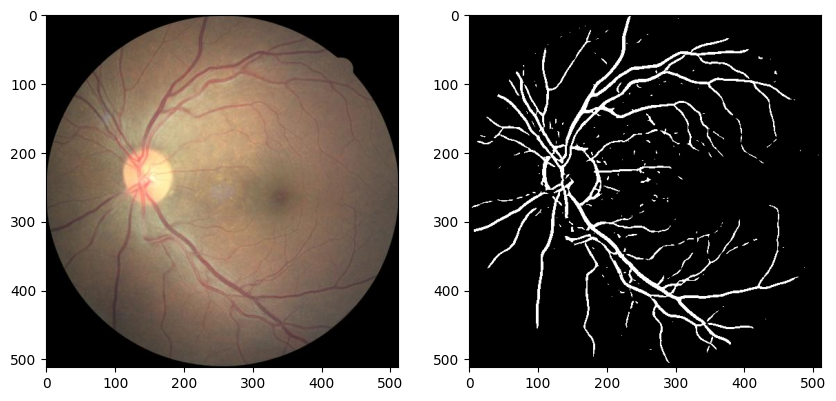

In [11]:
from skimage.filters.ridges import sato, frangi
import numpy as np
import dataloader
import time
import matplotlib.pyplot as plt
from PIL import Image
import random

sig = [2]
plt.rcParams["figure.figsize"] = (10, 10)

#random.shuffle(image_files)
for i, image_path in enumerate(image_files[:1]):

    img_orig = Image.open(image_path)
    img_np = np.array(Image.open(image_path).convert('L'))
    img_np = dataloader.zscore_norm(img_np)
    img_ret = (img_np > 2) + (img_np <=-1)
    
    #ridge = frangi(img_np, sigmas=[12, 14, 16, 18])
    ridge = sato(img_np, sigmas=sig)

    images = ['orig', 'vessel threshold', 'ridge filter']

    print(f"Processing image {i}")

    plt.subplot(1, 2, 1)
    plt.imshow(img_orig)

    plt.subplot(1, 2, 2)
    plt.imshow((1 - img_ret) * (ridge>0.05), cmap='gray')

    plt.show()

    #time.sleep(2)

In [44]:
print(img_np.shape)

(1944, 2592)


These vessel annotations are not perfect but they can be a good start.

### **Generating annotated data and model training**
Let us now train a 2D UNet model to segment these vessels using the noisy annotations we just created

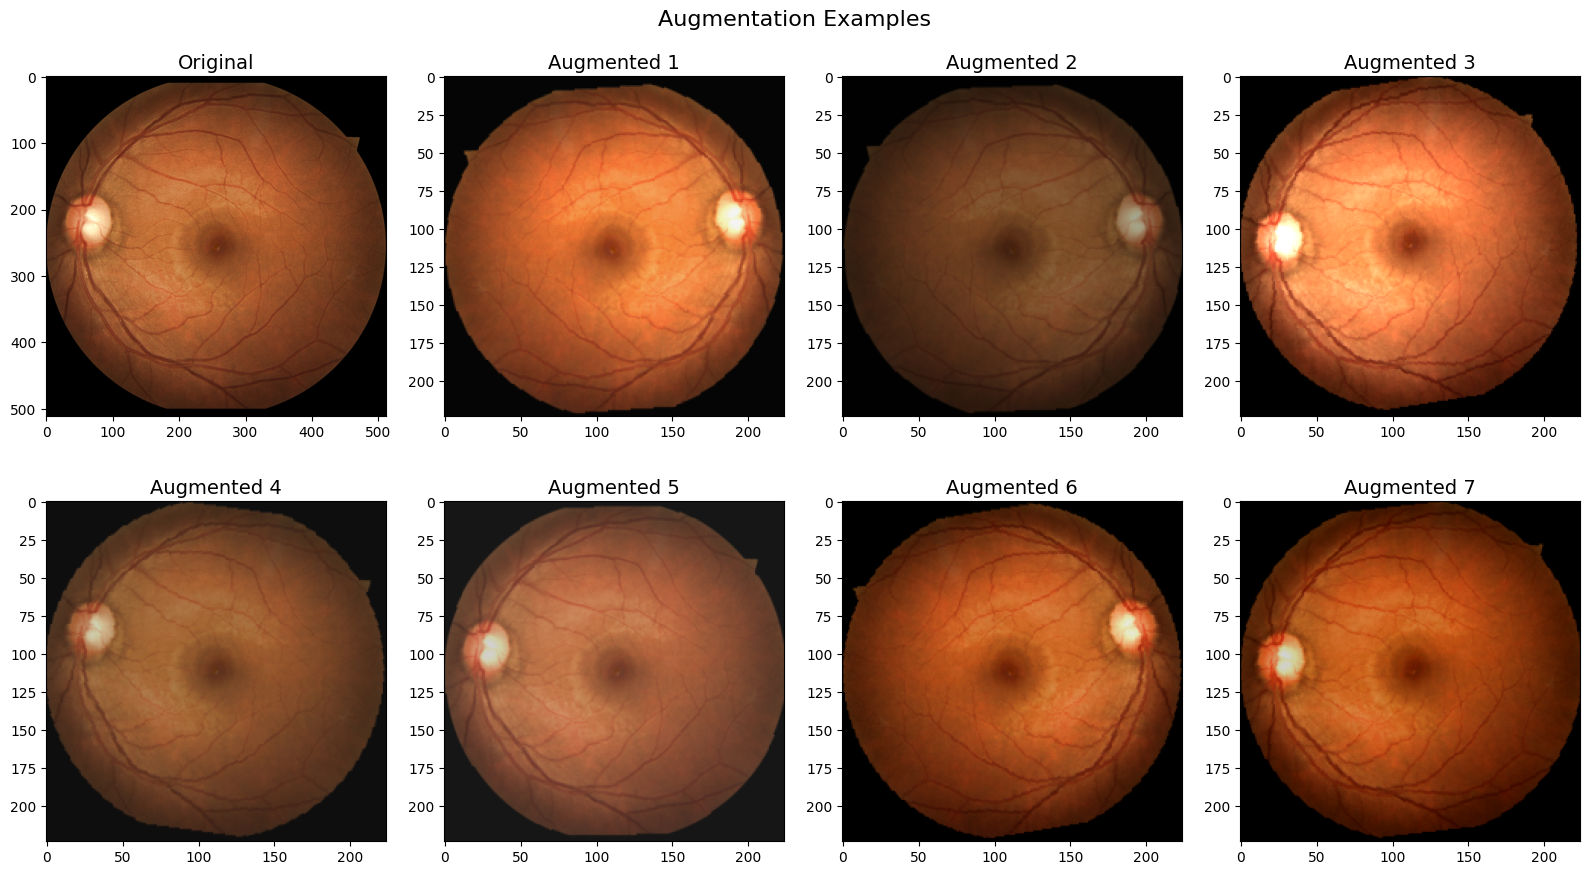

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
from src.utils import crop_and_pad_image
from torchvision import transforms as T

# Load the source image
image_path = image_files[2]  # Assuming image_files is defined elsewhere
src_image = Image.open(image_path)

# Crop and pad the image
cropped_image = crop_and_pad_image(image_path)

# Define the transformation
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomAffine(degrees=10, translate=(0.01, 0.01), scale=(0.99, 1.01)),
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.01),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
])

# Apply the transformation multiple times and show the results
num_augmentations = 7
fig, axes = plt.subplots(2, 4, figsize=(16, 9))

# Flatten the axes array
axes = axes.flatten()

# Set title for the entire figure
fig.suptitle("Augmentation Examples", fontsize=16)

# Original cropped image
axes[0].imshow(cropped_image)
axes[0].set_title("Original", fontsize=14)

# Apply augmentation and display
for i in range(1, num_augmentations + 1):
    augmented_image = transform(cropped_image).permute(1, 2, 0)
    axes[i].imshow(augmented_image)
    axes[i].set_title(f"Augmented {i}", fontsize=14)

# Hide remaining axes
for ax in axes[num_augmentations + 1:]:
    ax.axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()

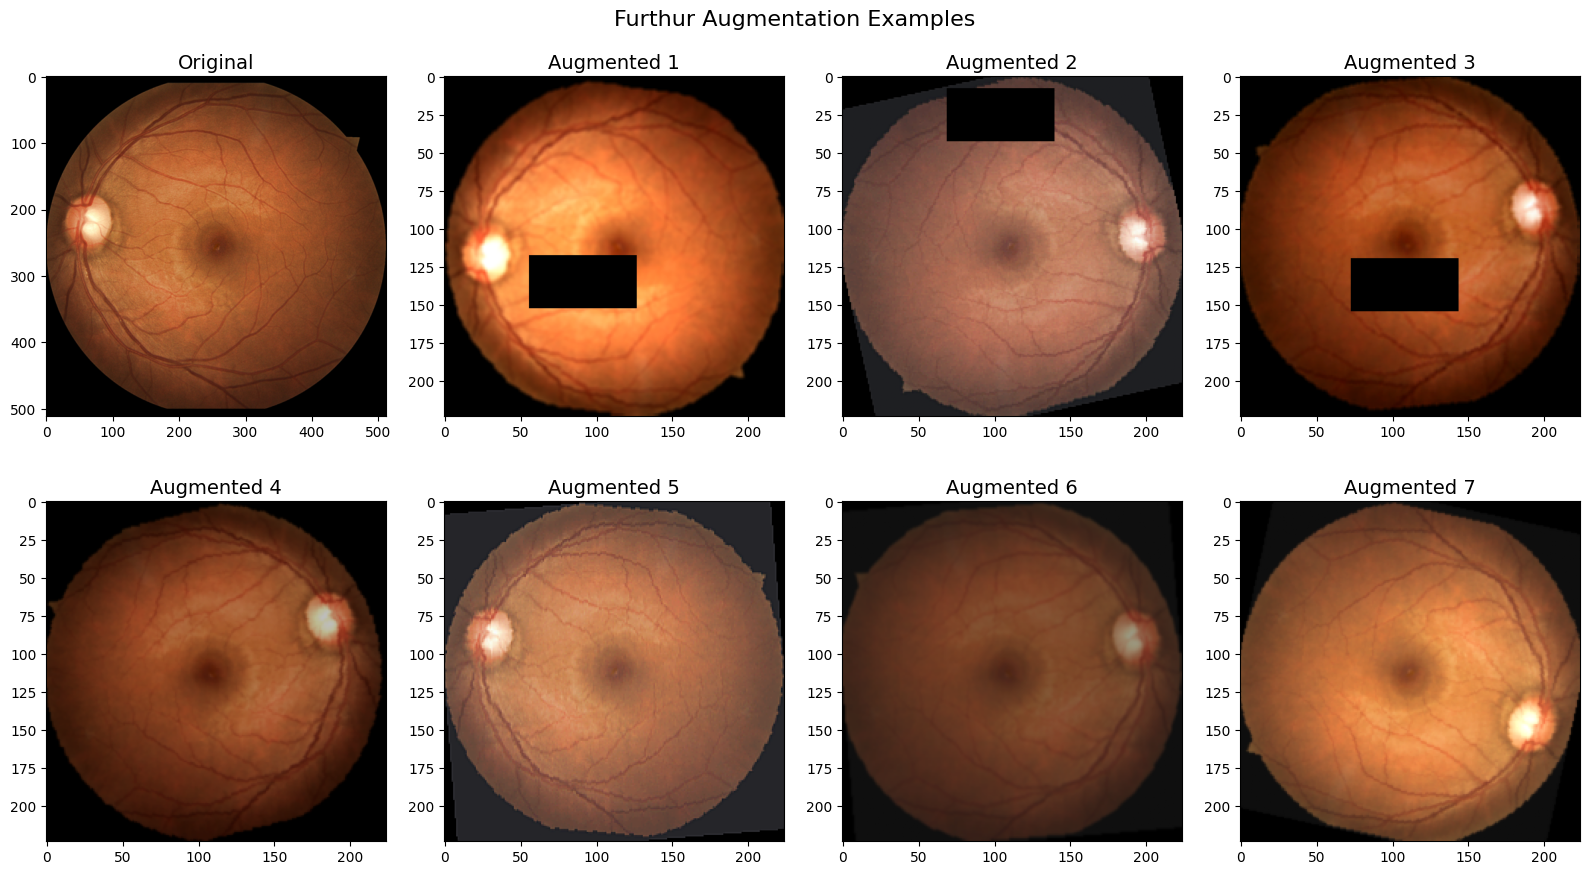

In [32]:
from PIL import Image
import matplotlib.pyplot as plt
from src.utils import crop_and_pad_image
from torchvision import transforms as T

# Load the source image
image_path = image_files[2]  # Assuming image_files is defined elsewhere
src_image = Image.open(image_path)

# Crop and pad the image
cropped_image = crop_and_pad_image(image_path)

# Define the transformation
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomAffine(degrees=10, translate=(0.01, 0.01), scale=(0.99, 1.01)),
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.01),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.RandomVerticalFlip(p=0.5),
    T.GaussianBlur(kernel_size=3),  # You can adjust kernel size as needed
    T.RandomResizedCrop(size=(224, 224), scale=(0.99, 1.0), ratio=(0.75, 1.333)),
    T.RandomAdjustSharpness(sharpness_factor=2),
    T.RandomAutocontrast(),
    T.ToTensor(),
    T.RandomErasing(p=0.2, scale=(0.05, 0.05), ratio=(0.5, 0.5)),
])

# Apply the transformation multiple times and show the results
num_augmentations = 8
fig, axes = plt.subplots(2, num_augmentations // 2, figsize=(16, 9))

# Flatten the axes array
axes = axes.flatten()

# Set title for the entire figure
fig.suptitle("Furthur Augmentation Examples", fontsize=16)

# Original cropped image
axes[0].imshow(cropped_image)
axes[0].set_title("Original", fontsize=14)

# Apply augmentation and display
for i in range(1, num_augmentations):
    augmented_image = transform(cropped_image).permute(1, 2, 0)
    axes[i].imshow(augmented_image)
    axes[i].set_title(f"Augmented {i}", fontsize=14)

# Hide remaining axes
for ax in axes[num_augmentations:]:
    ax.axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()